### Import dataset and libraries

In [57]:
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import statistics as stat
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
import random
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
sns.set_theme(style="white")


Test = pd.read_csv('project_data/project_data/test_dataset.csv')
Train = pd.read_csv('project_data/project_data/train_dataset.csv')
KWEembeddings  = np.load("project_data/project_data/features_doc2vec/features_doc2vec/train_doc2vec_features_plot_keywords.npy")
Gembeddings = np.load("project_data/project_data/features_doc2vec/features_doc2vec/train_doc2vec_features_genre.npy")
Tembeddings = np.load("project_data/project_data/features_fasttext/features_fasttext/train_fasttext_title_embeddings.npy")

KeyWordEmbeddings = pd.DataFrame(KWEembeddings)
GenreEmbeddings = pd.DataFrame(Gembeddings)
TitleEmbeddings = pd.DataFrame(Tembeddings)

### convert ratings to a scale

In [58]:
ratings = Train["content_rating"]

ratingsFreqList = []

for i in Train["content_rating"]:
    ratingsFreqList.append(i)

#print(genreFreqList)
count = Counter(ratingsFreqList)
print(count)

#1 G approved GP passed ✅
#2 PG or pg 13 or anything with 13 ✅
#3 M, not rated, unrated
#4 R
#5 X or NC 17
def convertRatings(row):
    if 'pg' in row.lower() or '13' in row.lower(): 
        return 2
    if row.lower() == 'g' or row.lower() == 'gp' or row.lower() == "passed":
        return 1
    if 'M' in row.lower() or row.lower() == "no rated" or row.lower() == "unrated":
        return 3
    if row.lower() == "r":
        return 4
    if row.lower() == "x" or "NC" in row.lower():
        return 5
    return 3

ratings = ratings.apply(lambda x: convertRatings(x))

Counter({'R': 1362, 'PG-13': 1039, 'PG': 458, 'G': 68, 'Not Rated': 27, 'Unrated': 19, 'Approved': 14, 'X': 9, 'NC-17': 3, 'M': 2, 'Passed': 2, 'GP': 1})


### produce continent encoding from country of origin

In [59]:
#get frequencies of countries
countryFreqList = []
for i in Train["country"]:
    countryFreqList.append(i)
count = Counter(countryFreqList)
print(count)


cont = Train["country"]
sub_region = pd.DataFrame("BLANK", index=np.arange(len(cont)), columns=["sub_region", "continent"]) 
cont = pd.concat([cont,sub_region],axis=1)

#load datra set in for match to sub_region and continent
countryTable = pd.read_csv("C:/Users/HAWal/Desktop/Machine learning Proj 2/contToreg.csv")


def getRegion(row):
    val = countryTable.loc[countryTable["country"] == row["country"]]
    if len(val) == 0:
        row["sub_region"] = "Northern America"
        row["continent"] = "Americas"
        return row
    row["sub_region"] = val.iloc[0]["sub_region"]
    row["continent"] = val.iloc[0]["continent"]
    return row
cont = cont.apply(lambda x: getRegion(x),axis=1)


def OneHotEncodeSingleCot(row):
    row[row["continent"]] += 1
    return row

continentFreqList = []
for value in cont["continent"]:
    continentFreqList.append(value)
count2 = Counter(continentFreqList)
print(count2)


labels = list(count2.keys())
EncodedCont = pd.DataFrame(0, index=np.arange(len(Train)), columns=labels) 
EncodedCont["continent"] = cont["continent"].copy(deep=True)
EncodedCont = EncodedCont.apply(lambda x: OneHotEncodeSingleCot(x), axis=1)

EncodedCont = EncodedCont.drop(columns=["continent"])

Counter({'USA': 2382, 'UK': 255, 'France': 86, 'Germany': 61, 'Canada': 46, 'Australia': 32, 'Spain': 21, 'Japan': 12, 'New Zealand': 10, 'China': 9, 'Hong Kong': 9, 'Italy': 8, 'South Korea': 7, 'Denmark': 6, 'Mexico': 6, 'Ireland': 6, 'Brazil': 4, 'India': 3, 'Thailand': 3, 'Norway': 3, 'South Africa': 3, 'Netherlands': 3, 'Argentina': 3, 'Iran': 3, 'Hungary': 2, 'Romania': 2, 'Russia': 2, 'Czech Republic': 2, 'Taiwan': 2, 'Chile': 1, 'Afghanistan': 1, 'Israel': 1, 'Colombia': 1, 'West Germany': 1, 'Official site': 1, 'Aruba': 1, 'Finland': 1, 'Iceland': 1, 'Poland': 1, 'Belgium': 1, 'New Line': 1, 'Indonesia': 1})
Counter({'Americas': 2447, 'Europe': 461, 'Asia': 51, 'Oceania': 42, 'Africa': 3})


### (Not Used) convert gross, CPI adjust in terms of release date

In [60]:
import cpi

CPIAdjusted = Train[["title_year","gross"]]

CPIAdjusted["ADJUSTED"] = CPIAdjusted.apply(
    lambda x: cpi.inflate(x.gross, x.title_year), axis=1
)

CPIAdjusted = CPIAdjusted.drop(columns=["gross","title_year"],axis=1)

C:\Users\HAWal\AppData\Local\Temp\ipykernel_12040\2600979657.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPIAdjusted["ADJUSTED"] = CPIAdjusted.apply(


### Data sets, standardised and not

In [61]:
numericColumnSet = ['num_critic_for_reviews','duration','director_facebook_likes','actor_3_facebook_likes','actor_1_facebook_likes','gross','num_voted_users','cast_total_facebook_likes','facenumber_in_poster','num_user_for_reviews','title_year','actor_2_facebook_likes','movie_facebook_likes','average_degree_centrality']
### above: column names of numeric columns in base data set

###
### UNSCALED DATA SETS
###

### only numeric data
NumericDataSet = pd.concat([Train[numericColumnSet],ratings], axis = 1)

### Numeric data + one hot encoded continent
PreTotalData = pd.concat([Train[numericColumnSet],EncodedCont,ratings], axis = 1)
PreTotalData.columns = PreTotalData.columns.astype(str)

### Full un stadardised data set with all embeddings
TotalData = pd.concat([Train[numericColumnSet],EncodedCont,ratings,TitleEmbeddings,KeyWordEmbeddings,GenreEmbeddings], axis = 1)
TotalData.columns = TotalData.columns.astype(str)

### CPI adjusted data
CPIdata = pd.concat([TotalData,CPIAdjusted],axis=1)
CPIdata.drop(columns=["gross"],axis=1)

###
### STANDARDISED DATA SETS
###
scaler = StandardScaler()

### stadardised PreTotalData
S_PreTotalData = scaler.fit_transform(PreTotalData)
S_PreTotalData = pd.DataFrame(S_PreTotalData)
S_PreTotalData.columns = PreTotalData.columns

### standardised TotalData
c = scaler.fit_transform(TotalData)
S_TotalData = pd.DataFrame(c)
S_TotalData.columns = TotalData.columns

### stadardised CPI dataset
c = scaler.fit_transform(CPIdata)
S_CPIdata = pd.DataFrame(c)
S_CPIdata.columns = CPIdata.columns


### exploratory graphs

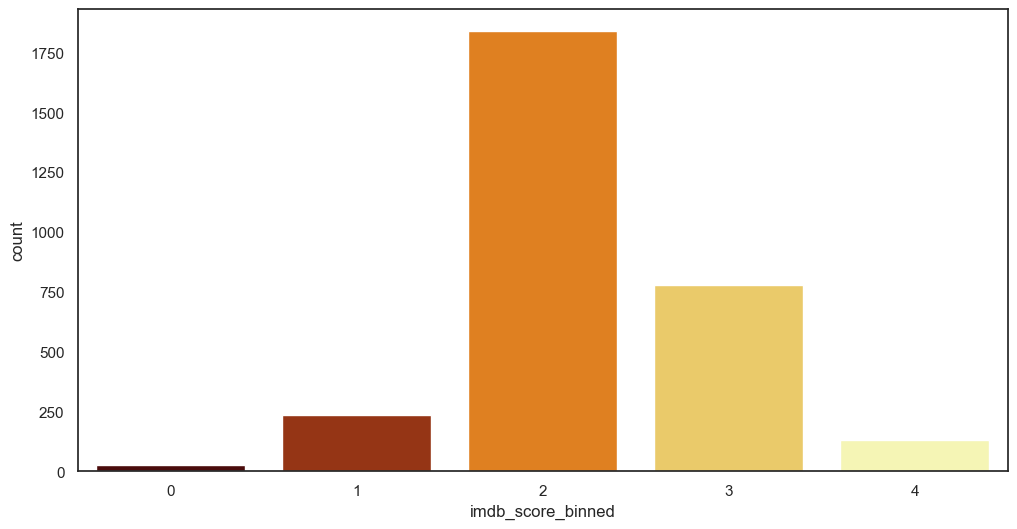

c:\Users\HAWal\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HAWal\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HAWal\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HAWal\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

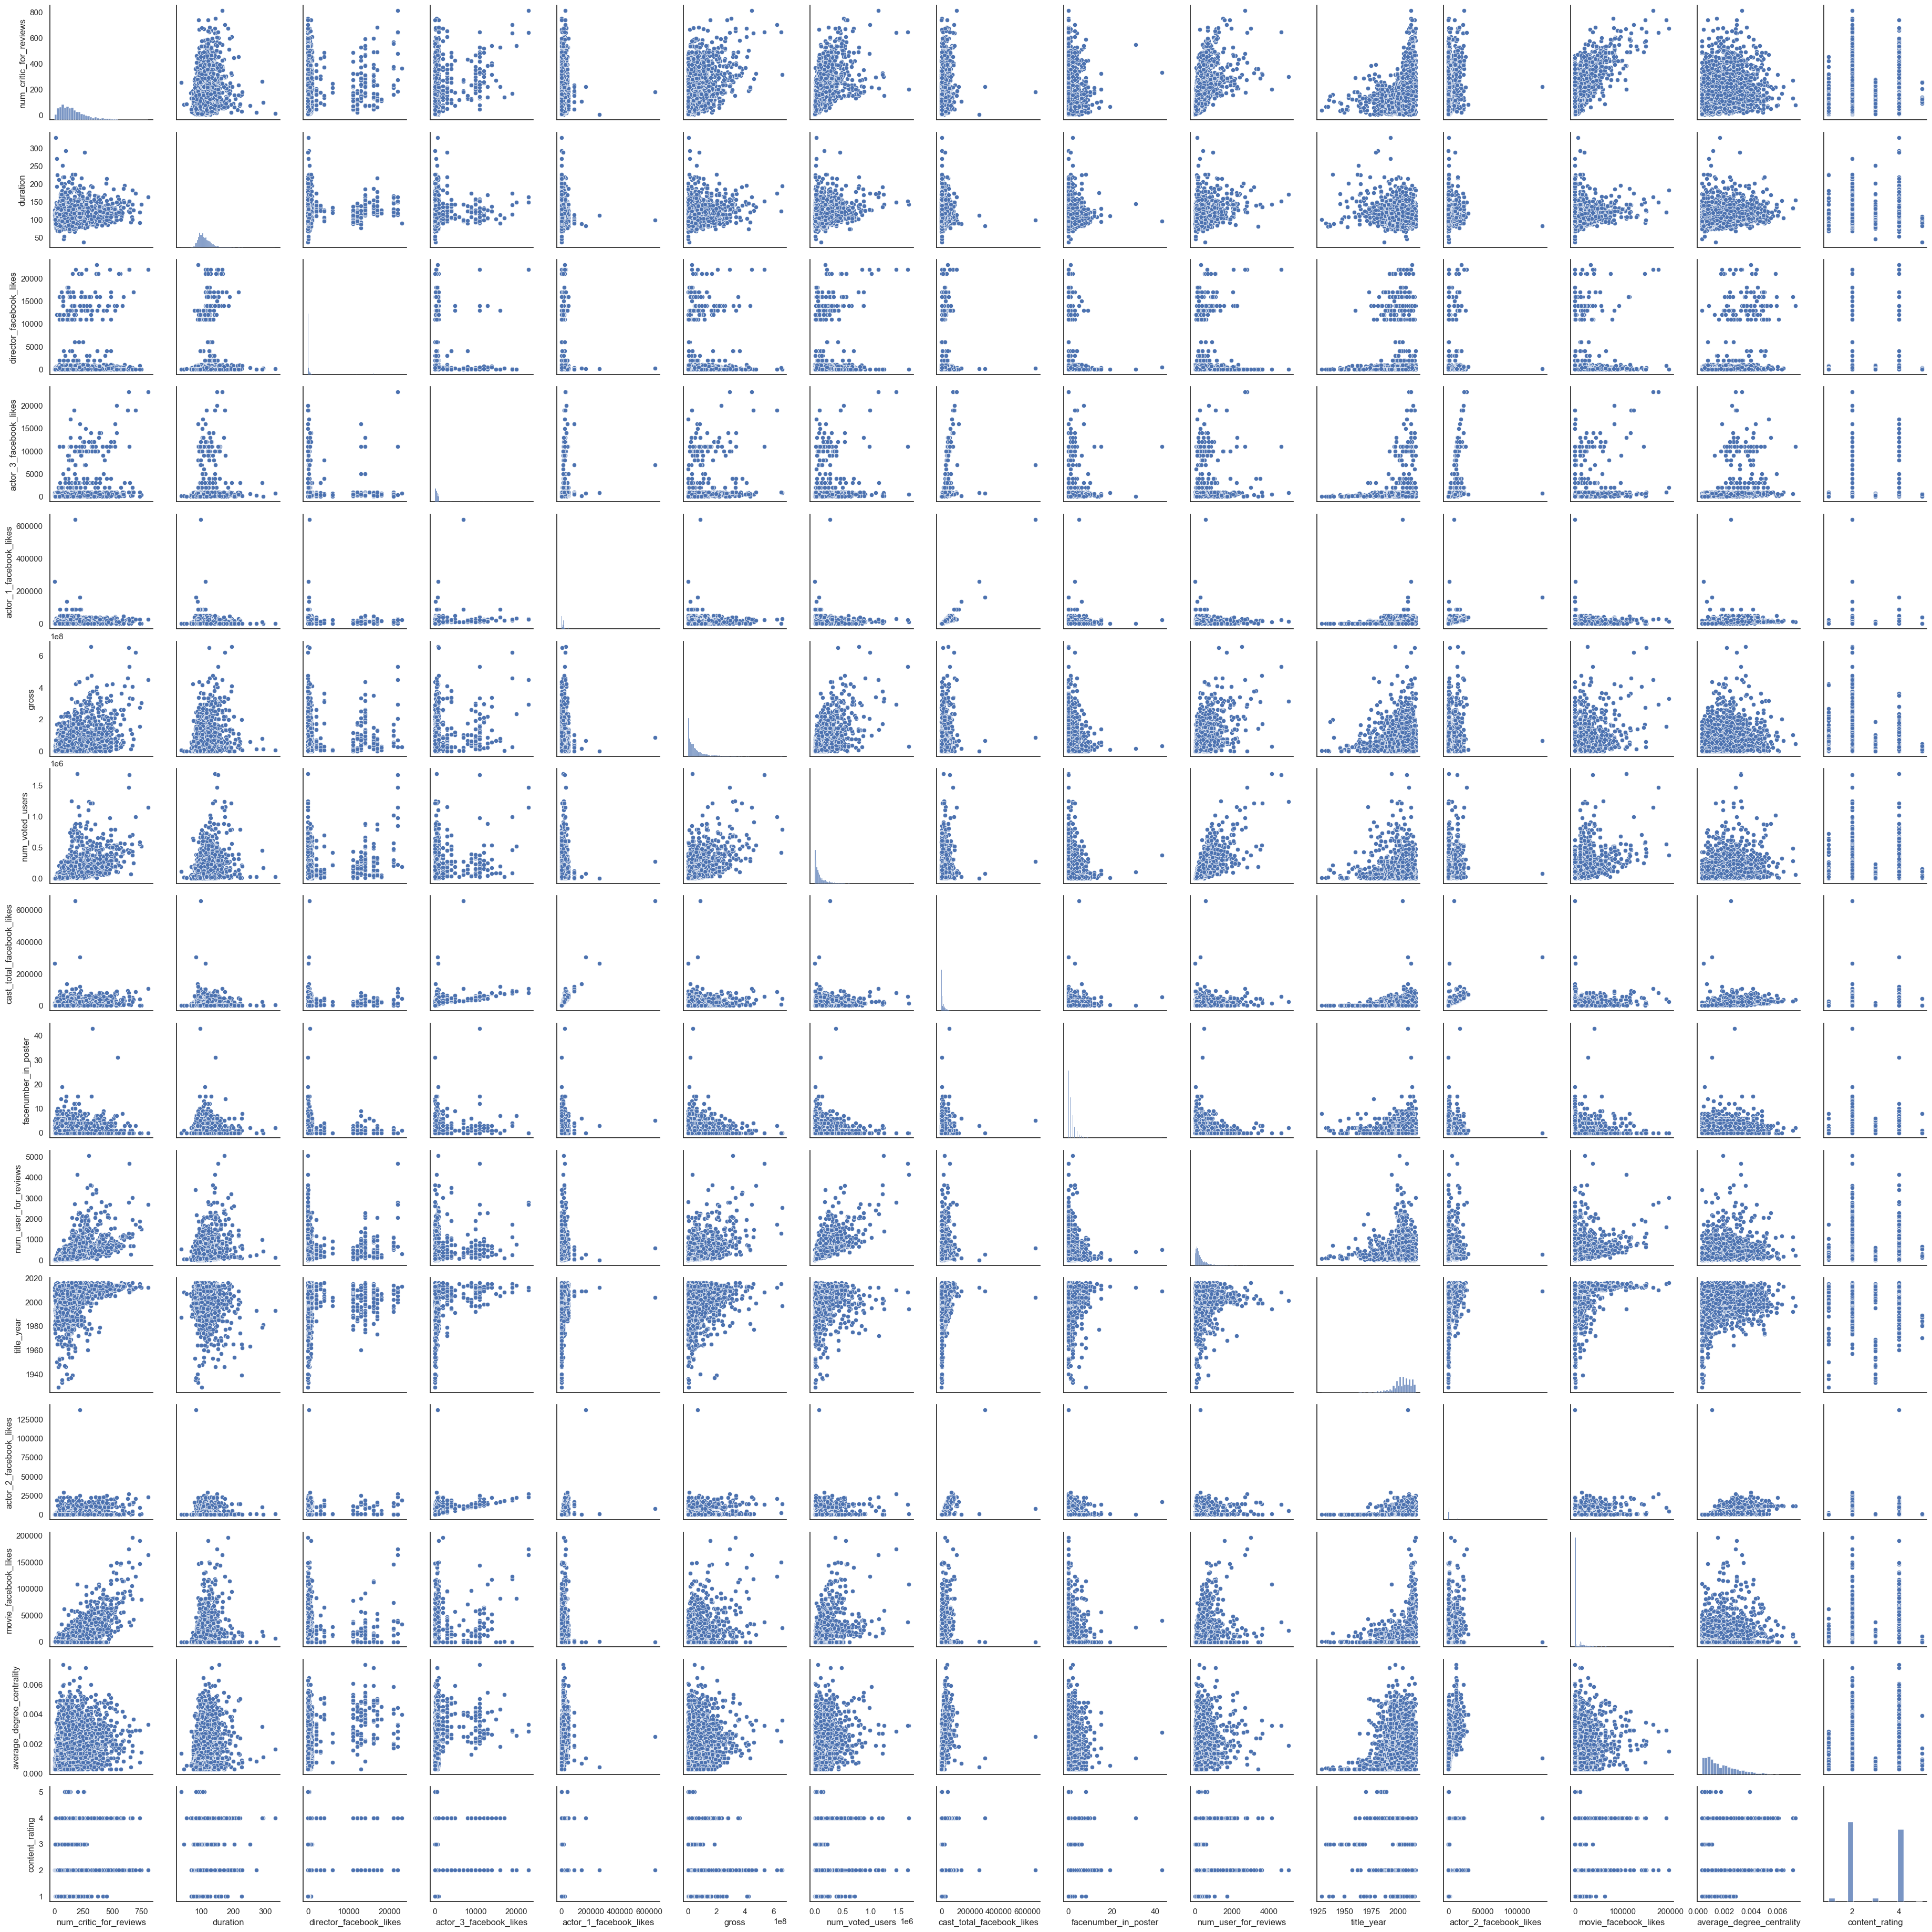

<Axes: >

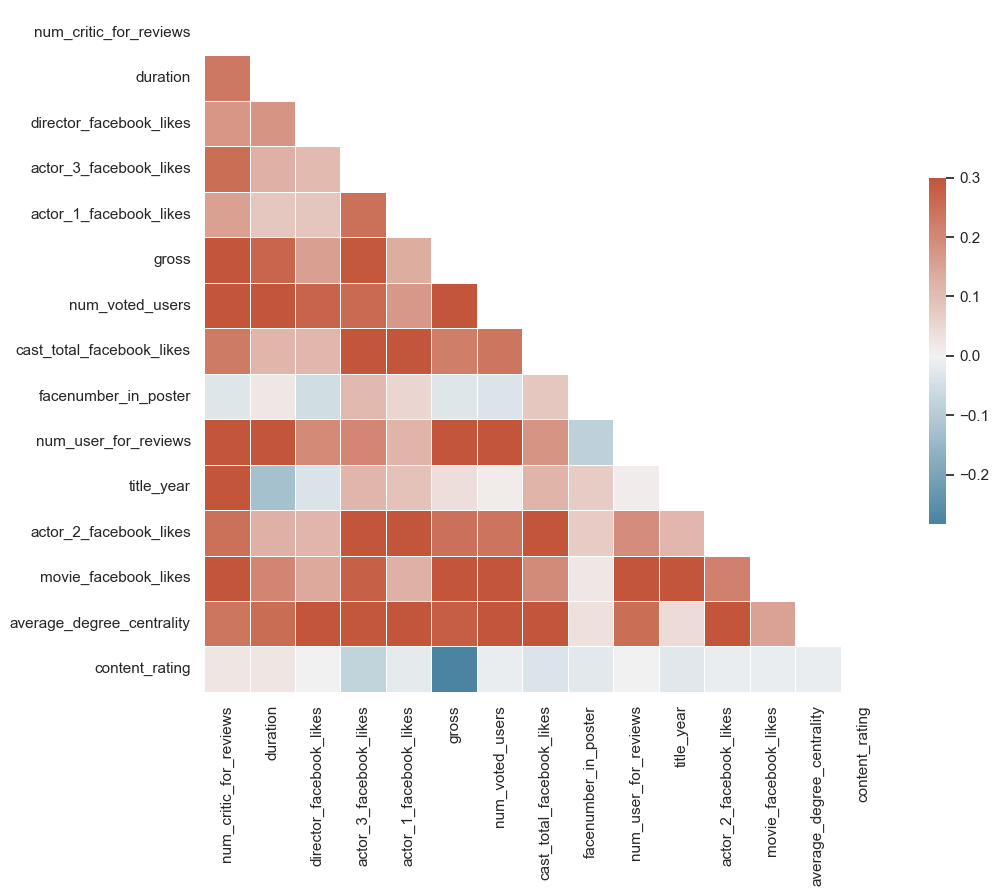

In [62]:
colors = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
freqScore = Train["imdb_score_binned"]
freq = freqScore.value_counts().to_dict()

sns.countplot(x = "imdb_score_binned",data = Train,palette="afmhot")
plt.show()

sns.pairplot(NumericDataSet)
plt.show()


corr = NumericDataSet.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Generating PLS datasets

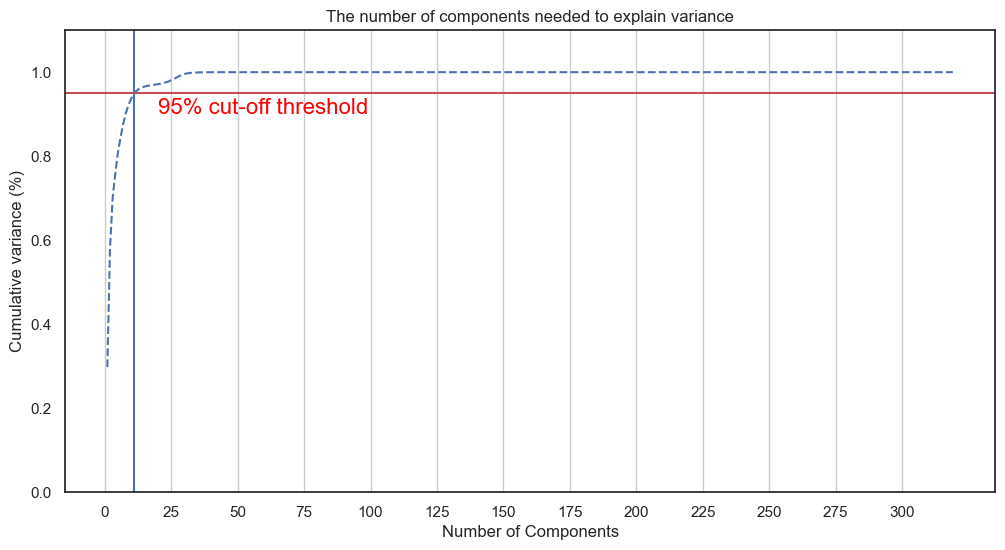

In [63]:
prev = 0
pls = PLSRegression(n_components=len(S_TotalData.columns)-1,max_iter=1000000)
pls.fit(S_TotalData, Train["imdb_score_binned"])
c = pls.transform(S_TotalData)

tempList = []
for i in range(1,len(S_TotalData.columns)):
    Itemp = c[:,i-1]
    Jtemp = Train["imdb_score_binned"].to_numpy()
    tempList.append(np.abs(np.cov(Itemp,Jtemp)[1,0]))


import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, len(S_TotalData.columns), step=1)
y = np.cumsum(tempList)/sum(tempList)

plt.ylim(0.0,1.1)
plt.plot(xi, y, linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(S_TotalData.columns), step=25)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(20, 0.9, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.vlines(11,0,1.2)
plt.show()


PLS_TotalData = c[:,0:11]
PLS_DF_TotalData = pd.DataFrame(c[:,0:11])

### Initial Default Model Exploration 

In [64]:
kf = KFold(n_splits=5,random_state=10201331,shuffle=True) 

LogModel = LogisticRegression(max_iter=100000)
CsvModel = SVC()

for k in [LogModel, CsvModel]:
    kf = KFold(n_splits=10)
    for i in [TotalData,S_TotalData]:
        avgScore = []
        for j, (train_index, test_index) in enumerate(kf.split(i)):
            X = i.iloc[train_index]
            Y = Train.iloc[train_index]["imdb_score_binned"]
            Xt = i.iloc[test_index]
            Yt = Train.iloc[test_index]["imdb_score_binned"]
            k.fit(X,Y)
            avgScore.append(k.score(Xt,Yt))
        print("Score of Dataset with model:", k , " = ", stat.mean(avgScore))

for k in [LogModel, CsvModel]:
    kf = KFold(n_splits=10)
    for i in [PLS_TotalData]:
        avgScore = []
        for j, (train_index, test_index) in enumerate(kf.split(i)):
            X = i[train_index,:]
            Y = Train.iloc[train_index]["imdb_score_binned"]
            Xt = i[test_index,:]
            Yt = Train.iloc[test_index]["imdb_score_binned"]
            k.fit(X,Y)
            avgScore.append(k.score(Xt,Yt))
        print("Score of Dataset with model:", k , " = ", stat.mean(avgScore))

Score of Dataset with model: LogisticRegression(max_iter=100000)  =  0.6464518272425249
Score of Dataset with model: LogisticRegression(max_iter=100000)  =  0.643468438538206
Score of Dataset with model: SVC()  =  0.615171650055371
Score of Dataset with model: SVC()  =  0.6684385382059801
Score of Dataset with model: LogisticRegression(max_iter=100000)  =  0.7216921373200443
Score of Dataset with model: SVC()  =  0.7256832779623477


# GRID SEARCH SECTION

### Random Forest Grid Search

In [65]:
params = [{'max_depth': range(20,100,20),'n_estimators':range(50,500,75),'criterion':[ "gini", "entropy", "log_loss"]} ]

Rf = RandomForestClassifier(random_state=10000)

gs_RandomForest = GridSearchCV(Rf,
                               param_grid=params,
                               scoring='accuracy',
                               cv=4,
                               verbose=3)
gs_RandomForest.fit(S_TotalData, Train["imdb_score_binned"])
print(gs_RandomForest.best_params_, gs_RandomForest.best_score_)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[CV 1/4] END criterion=gini, max_depth=20, n_estimators=50;, score=0.666 total time=   2.0s
[CV 2/4] END criterion=gini, max_depth=20, n_estimators=50;, score=0.660 total time=   2.0s
[CV 3/4] END criterion=gini, max_depth=20, n_estimators=50;, score=0.656 total time=   2.1s
[CV 4/4] END criterion=gini, max_depth=20, n_estimators=50;, score=0.668 total time=   2.0s
[CV 1/4] END criterion=gini, max_depth=20, n_estimators=125;, score=0.664 total time=   5.2s


KeyboardInterrupt: 

### Logistic Regression Grid Search

In [67]:
params = [{'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}]

Lr = LogisticRegression(random_state=10000, warm_start=True, max_iter=1000000)

gs_logistic_regression = GridSearchCV(Lr, param_grid=params,scoring='accuracy',cv=4,verbose=3)

gs_logistic_regression.fit(PLS_TotalData, Train["imdb_score_binned"])

print(gs_logistic_regression.best_params_, gs_logistic_regression.best_score_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ..................solver=newton-cg;, score=0.734 total time=   0.0s
[CV 2/4] END ..................solver=newton-cg;, score=0.720 total time=   0.0s
[CV 3/4] END ..................solver=newton-cg;, score=0.719 total time=   0.0s
[CV 4/4] END ..................solver=newton-cg;, score=0.723 total time=   0.0s
[CV 1/4] END ........................solver=sag;, score=0.734 total time=   0.0s
[CV 2/4] END ........................solver=sag;, score=0.720 total time=   0.0s
[CV 3/4] END ........................solver=sag;, score=0.719 total time=   0.0s
[CV 4/4] END ........................solver=sag;, score=0.723 total time=   0.0s
[CV 1/4] END .......................solver=saga;, score=0.734 total time=   0.1s
[CV 2/4] END .......................solver=saga;, score=0.720 total time=   0.0s
[CV 3/4] END .......................solver=saga;, score=0.719 total time=   0.1s
[CV 4/4] END .......................solver=saga;,

### SVC Grid Search

In [69]:
params = [{'C': [0.5, 0.75, 1.00, 1.25, 1.50, 2.00, 2.5, 3.00, 5.00,7.5, 10.00,11,12,13,14,15,25],
            'kernel': ['poly', 'rbf', 'sigmoid']}]

Svc = SVC(random_state=10000)

gs_SVC = GridSearchCV(Svc, param_grid=params, scoring='accuracy', cv = 4, verbose = 3)

gs_SVC.fit(PLS_TotalData, Train['imdb_score_binned'])

print(gs_SVC.best_params_, gs_SVC.best_score_)

Fitting 4 folds for each of 51 candidates, totalling 204 fits
[CV 1/4] END ................C=0.5, kernel=poly;, score=0.691 total time=   0.0s
[CV 2/4] END ................C=0.5, kernel=poly;, score=0.702 total time=   0.0s
[CV 3/4] END ................C=0.5, kernel=poly;, score=0.680 total time=   0.0s
[CV 4/4] END ................C=0.5, kernel=poly;, score=0.695 total time=   0.0s
[CV 1/4] END .................C=0.5, kernel=rbf;, score=0.728 total time=   0.0s
[CV 2/4] END .................C=0.5, kernel=rbf;, score=0.719 total time=   0.0s
[CV 3/4] END .................C=0.5, kernel=rbf;, score=0.714 total time=   0.0s
[CV 4/4] END .................C=0.5, kernel=rbf;, score=0.716 total time=   0.0s
[CV 1/4] END .............C=0.5, kernel=sigmoid;, score=0.647 total time=   0.0s
[CV 2/4] END .............C=0.5, kernel=sigmoid;, score=0.609 total time=   0.0s
[CV 3/4] END .............C=0.5, kernel=sigmoid;, score=0.575 total time=   0.0s
[CV 4/4] END .............C=0.5, kernel=sigmoid

### ANOVA + Scaler + Logistic Regression

1 . mean : 0.7180427066001109 , std : 0.010758538724912748
3 . mean : 0.7197021630615641 , std : 0.014588154828886655
6 . mean : 0.722699944536883 , std : 0.016000423273652625
10 . mean : 0.7170399334442596 , std : 0.019235064103453863
15 . mean : 0.7057221297836939 , std : 0.015297986061948094
20 . mean : 0.6990626733222408 , std : 0.018176951636866678
30 . mean : 0.6877459789240156 , std : 0.013004417356830167
40 . mean : 0.6777526344980588 , std : 0.022252702329562536
60 . mean : 0.6694348308374931 , std : 0.0192687547360891
80 . mean : 0.6527992235163615 , std : 0.016796298167738283
100 . mean : 0.6318269550748752 , std : 0.01150759337819852


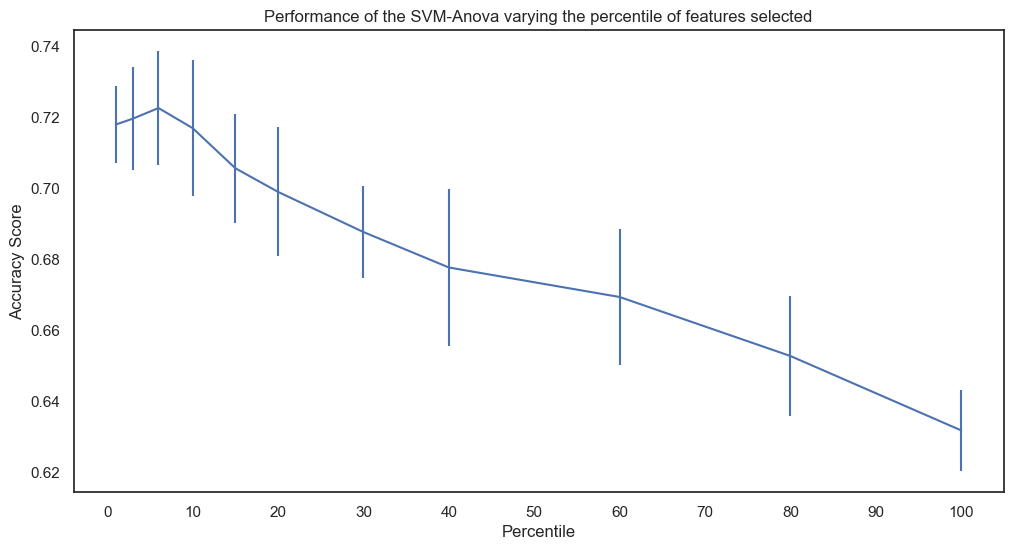

In [83]:
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Create a feature-selection transform, a scaler and an instance of SVM that we
# combine together to have a full-blown estimator

X = c
y = Train["imdb_score_binned"]

clf = Pipeline(
    [
        ("anova", SelectPercentile(f_classif)),
        ("scaler", StandardScaler()),
        ("svc", LogisticRegression(solver = 'newton-cg')),
    ]
)

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score

score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X, y)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())
    print(percentile, ". mean :", this_scores.mean(), ", std :", this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("Performance of the SVM-Anova varying the percentile of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Accuracy Score")
plt.axis("tight")
plt.show()

### Neural Network

['c:\\Users\\HAWal\\Desktop\\Machine learning Proj 2', 'c:\\Users\\HAWal\\anaconda3\\python311.zip', 'c:\\Users\\HAWal\\anaconda3\\DLLs', 'c:\\Users\\HAWal\\anaconda3\\Lib', 'c:\\Users\\HAWal\\anaconda3', '', 'C:\\Users\\HAWal\\AppData\\Roaming\\Python\\Python311\\site-packages', 'c:\\Users\\HAWal\\anaconda3\\Lib\\site-packages', 'c:\\Users\\HAWal\\anaconda3\\Lib\\site-packages\\win32', 'c:\\Users\\HAWal\\anaconda3\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\HAWal\\anaconda3\\Lib\\site-packages\\Pythonwin', '/Users/HAWal/AppData/Roaming/Python/Python311/Scripts']
['c:\\Users\\HAWal\\Desktop\\Machine learning Proj 2', 'c:\\Users\\HAWal\\anaconda3\\python311.zip', 'c:\\Users\\HAWal\\anaconda3\\DLLs', 'c:\\Users\\HAWal\\anaconda3\\Lib', 'c:\\Users\\HAWal\\anaconda3', '', 'C:\\Users\\HAWal\\AppData\\Roaming\\Python\\Python311\\site-packages', 'c:\\Users\\HAWal\\anaconda3\\Lib\\site-packages', 'c:\\Users\\HAWal\\anaconda3\\Lib\\site-packages\\win32', 'c:\\Users\\HAWal\\anaconda3\\Lib\\sit

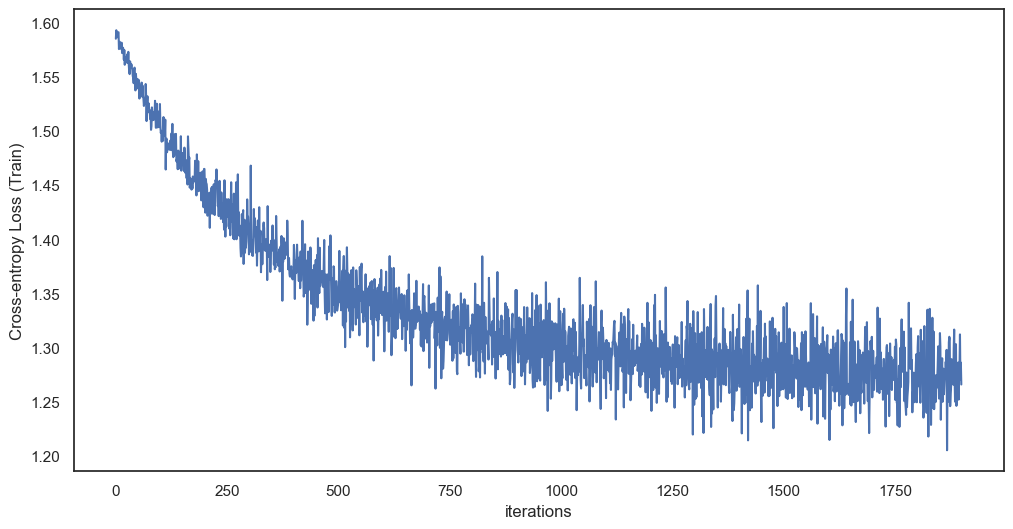

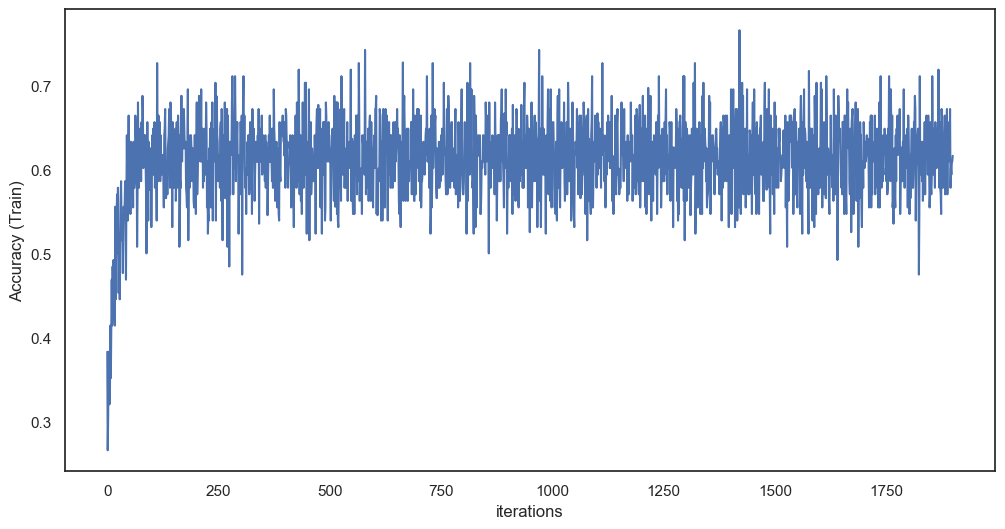

In [85]:

import sys
print (sys.path)
sys.path.append("/Users/HAWal/AppData/Roaming/Python/Python311/Scripts")
print (sys.path)

import torch
import torch.nn.functional as F
import torch.utils.data as dataUtils

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from collections import Counter

import matplotlib.pyplot as plt

import time


class NeuralNetwork(torch.nn.Module):
    def __init__(self, nInputs, l1, l2, l3, nClasses):
        super(NeuralNetwork, self).__init__()
        self.Numerical = torch.nn.Sequential(
            torch.nn.Linear(20, 10),
            torch.nn.Sigmoid(),
            torch.nn.Linear(10,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Embeddings1 = torch.nn.Sequential(
            torch.nn.Linear(100, 20),
            torch.nn.Sigmoid(),
            torch.nn.Linear(20,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Embeddings2 = torch.nn.Sequential(
            torch.nn.Linear(100,20),
            torch.nn.Sigmoid(),
            torch.nn.Linear(20,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Embeddings3 = torch.nn.Sequential(
            torch.nn.Linear(100,20),
            torch.nn.Sigmoid(),
            torch.nn.Linear(20,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Combination = torch.nn.Sequential(
            torch.nn.Linear(40,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25),
            torch.nn.Linear(10,nClasses),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        a = self.Numerical(x[:,0:20])
        b = self.Embeddings1(x[:,20:120])
        c = self.Embeddings2(x[:,120:220])
        d = self.Embeddings3(x[:,220:320])
        combined = torch.cat((a,b,c,d), dim=1)
        out = self.Combination(combined)
        return out

def test(model, criterion, test_loader):
    test_loss = 0.
    test_preds, test_labels = list(), list()
    for i, data in enumerate(test_loader):
        x, labels = data

        with torch.no_grad():
            logits = model(x)
            predictions = torch.argmax(logits, dim=1)
            test_loss += criterion(input=logits, target=labels).item()
            test_preds.append(predictions)
            test_labels.append(labels)

    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)

    test_accuracy = torch.eq(test_preds, test_labels).float().mean().item()

    print('[TEST] Mean loss {:.4f} | Accuracy {:.4f}'.format(test_loss/len(test_loader), test_accuracy))


def train(model, train_loader, test_loader, optimizer, n_epochs=10):
    LOG_INTERVAL = 250
    running_loss, running_accuracy = list(), list()
    start_time = time.time()
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(n_epochs):

        epoch_loss = 0.

        for i, data in enumerate(train_loader):

            x, labels = data

            logits = model(x)

            predictions = torch.argmax(logits, dim=1)
            train_acc = torch.mean(torch.eq(predictions, labels).float()).item()

            loss = criterion(input=logits, target=labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_loss.append(loss.item())
            running_accuracy.append(train_acc)

            epoch_loss += loss.item()

            if i % LOG_INTERVAL == 0:
                deltaT = time.time() - start_time
                mean_loss = epoch_loss / (i+1)
                print('[TRAIN] Epoch {} [{}/{}]| Mean loss {:.4f} | Train accuracy {:.5f} | Time {:.2f} s'.format(epoch, 
                    i, len(train_loader), mean_loss, train_acc, deltaT))

        print('Epoch complete! Mean loss: {:.4f}'.format(epoch_loss/len(train_loader)))

        test(model, criterion, test_loader)
    return running_loss, running_accuracy


xTrain, xTest, yTrain, yTest = train_test_split(S_TotalData, Train["imdb_score_binned"], test_size=0.2, random_state=981488)

xTrain = torch.tensor(xTrain.values, dtype=torch.float)
yTrain = torch.tensor(yTrain.values).type(torch.LongTensor)
trainData = dataUtils.TensorDataset(xTrain, yTrain)
trainLoader = dataUtils.DataLoader(trainData, batch_size=128, shuffle=True)

xTest = torch.tensor(xTest.values, dtype=torch.float)
yTest = torch.tensor(yTest.values).type(torch.LongTensor)
testData = dataUtils.TensorDataset(xTest, yTest)
testLoader = dataUtils.DataLoader(testData, batch_size=128, shuffle=False)

neuralNetwork = NeuralNetwork(len(S_TotalData.columns), 150, 100, 50, 5)

optimizer = torch.optim.SGD(neuralNetwork.parameters(), lr=1e-2, momentum=0.5)

nnLoss, nnAcc = train(neuralNetwork, trainLoader, testLoader, optimizer, 100)

plt.plot(nnLoss)
plt.xlabel("iterations")
plt.ylabel("Cross-entropy Loss (Train)")
plt.show()

plt.plot(nnAcc)
plt.xlabel("iterations")
plt.ylabel("Accuracy (Train)")
plt.show()